In [1]:
import time
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import pyaudio
import librosa
import librosa.display

In [2]:
matplotlib.rcParams["figure.figsize"] = (14, 4)

CHANNELS = 1
RATE = 44100
WIN_LENGTH = 2048
HOP_LENGTH = 512
SAMPLES_PER_BUFFER = 1024
print("sample resolution:", 1/RATE)
print("frame resolution:", HOP_LENGTH/RATE)
print("buffer length:", SAMPLES_PER_BUFFER/RATE)

sample resolution: 2.2675736961451248e-05
frame resolution: 0.011609977324263039
buffer length: 0.023219954648526078


# test

In [3]:
# generate click sound for test
click_duration = 8*4
click_bps = 1
click_interval = int(RATE/click_bps)
total_length = int(click_duration*RATE)

click = librosa.clicks(np.arange(0, click_duration, 1/click_bps), sr=RATE, length=total_length)

In [4]:
# output stream callback
playback_index = 0
playback_info = []
def output_callback(in_data, frame_count, time_info, status):
    global playback_index
    current_time = time.time() - reference_time
    dac_time = time_info["output_buffer_dac_time"]
    playback_info.append((current_time, dac_time, playback_index))

    if playback_index >= click.shape[0]:
        return None, pyaudio.paComplete

    out_data = click[playback_index:playback_index+frame_count].tobytes()
    playback_index += frame_count
    return out_data, pyaudio.paContinue

In [5]:
# input stream callback
record = np.zeros(total_length+int(0.5*RATE), dtype=np.float32)
record_index = 0
record_info = []
def input_callback(in_data, frame_count, time_info, status):
    global record_index
    current_time = time.time() - reference_time
    adc_time = time_info["input_buffer_adc_time"]
    record_info.append((current_time, adc_time, record_index))

    if record_index+frame_count > record.shape[0]:
        return None, pyaudio.paComplete

    audio_data = np.frombuffer(in_data, dtype=np.float32)
    record[record_index:record_index+frame_count] = audio_data
    record_index += frame_count

    return in_data, pyaudio.paContinue

In [6]:
# execute test
reference_time = time.time()

p = pyaudio.PyAudio()

input_stream = p.open(format=pyaudio.paFloat32,
                      channels=CHANNELS,
                      rate=RATE,
                      input=True,
                      output=False,
                      frames_per_buffer=SAMPLES_PER_BUFFER,
                      stream_callback=input_callback)
input_stream.start_stream()

time.sleep(0.2)

output_stream = p.open(format=pyaudio.paFloat32,
                       channels=CHANNELS,
                       rate=RATE,
                       input=False,
                       output=True,
                       frames_per_buffer=SAMPLES_PER_BUFFER,
                       stream_callback=output_callback)
output_stream.start_stream()

while output_stream.is_active() or input_stream.is_active():
    time.sleep(0.1)

output_stream.stop_stream()
input_stream.stop_stream()
output_stream.close()
input_stream.close()

p.terminate()

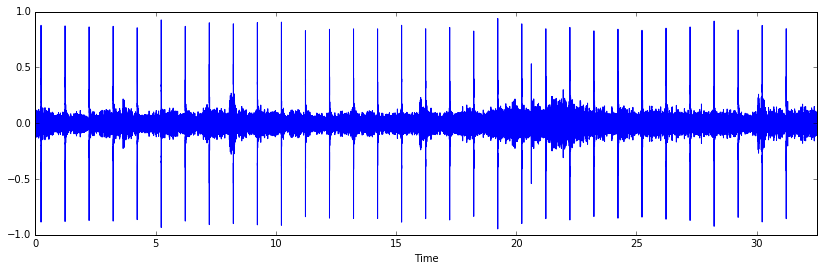

In [7]:
librosa.display.waveplot(record, sr=RATE)

# analysis

In [8]:
onset_indices = librosa.util.peak_pick(abs(record),
                                       int(0.03*RATE),
                                       int(0.00*RATE + 1),
                                       int(0.10*RATE),
                                       int(0.10*RATE + 1),
                                       0.5,
                                       int(0.03*RATE))
onset_times = onset_indices/RATE
print(len(onset_indices))
print(1-np.diff(onset_times))

32
[ 0.00000000e+00  2.26757370e-05 -2.26757370e-05  0.00000000e+00
  2.26757370e-05 -2.26757370e-05  0.00000000e+00  0.00000000e+00
  2.26757370e-05  0.00000000e+00 -2.26757370e-05  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.26757370e-05 -2.26757370e-05
  0.00000000e+00  0.00000000e+00 -2.26757370e-05  4.53514739e-05
 -2.26757370e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.26757370e-05
 -2.26757370e-05  0.00000000e+00  0.00000000e+00]


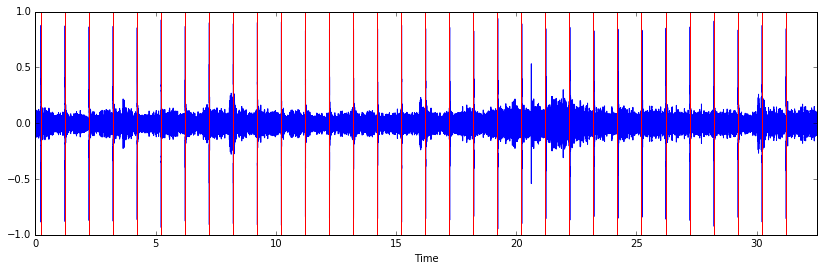

In [9]:
librosa.display.waveplot(record, sr=RATE)
matplotlib.pyplot.vlines(onset_times, -1, 1, color="r")
matplotlib.pyplot.show()

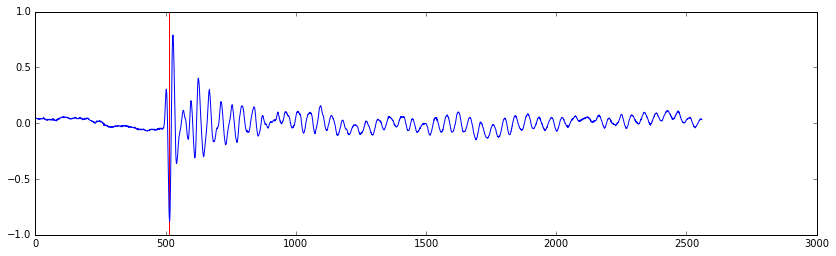

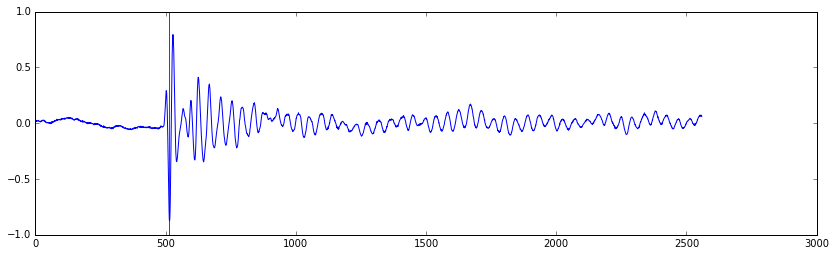

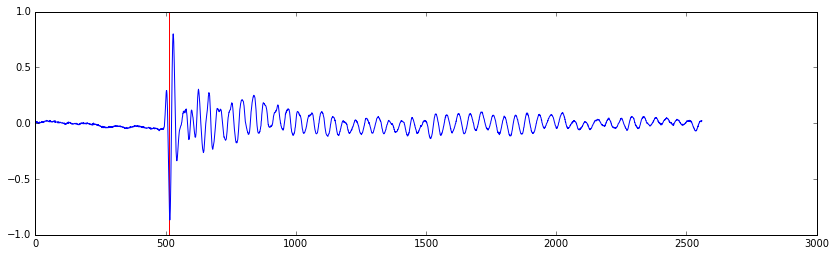

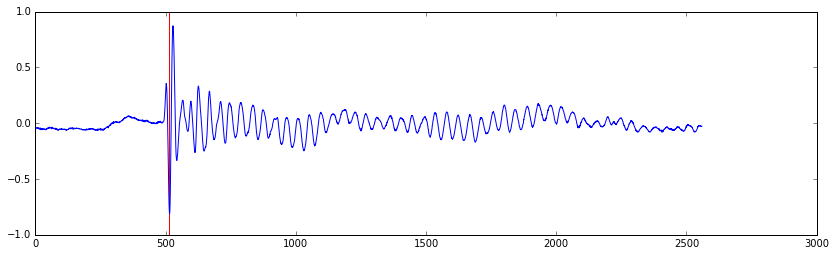

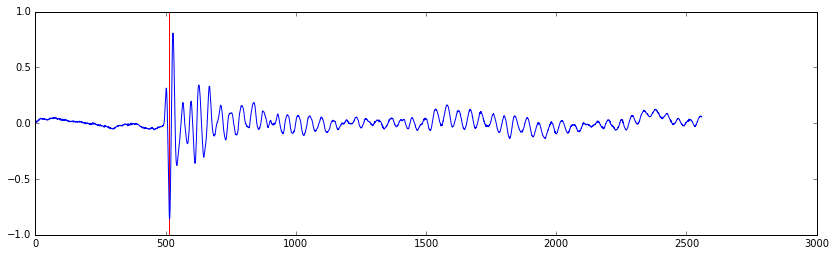

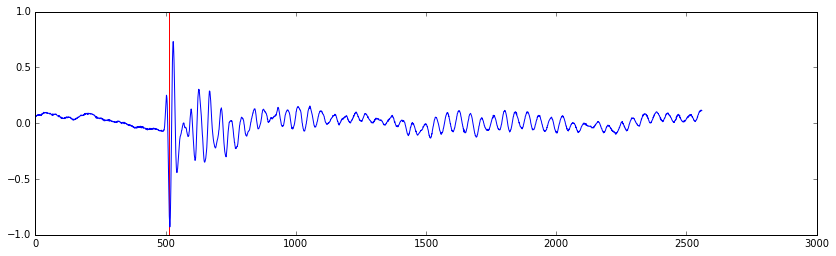

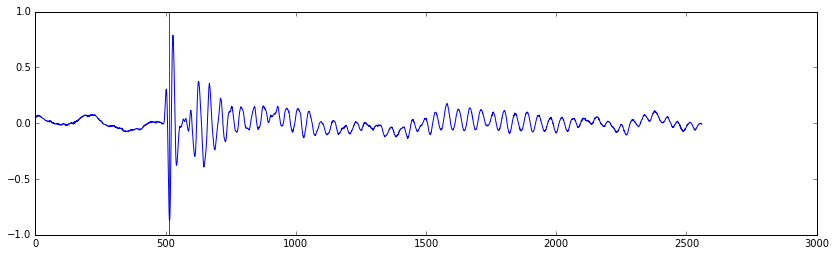

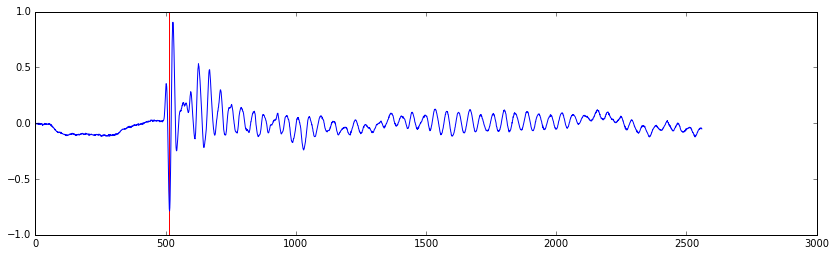

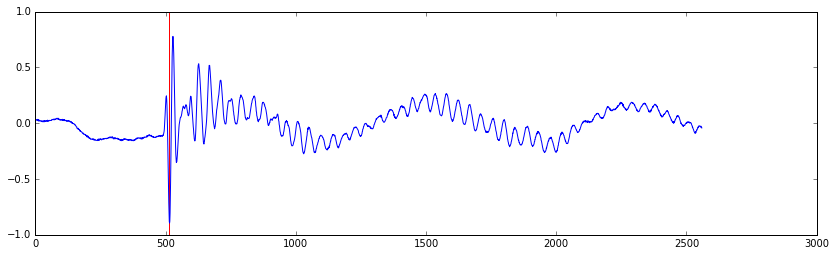

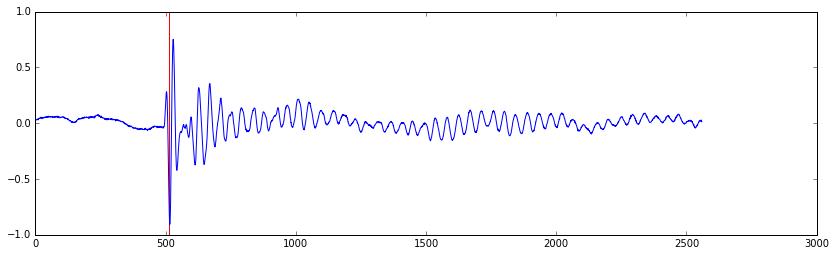

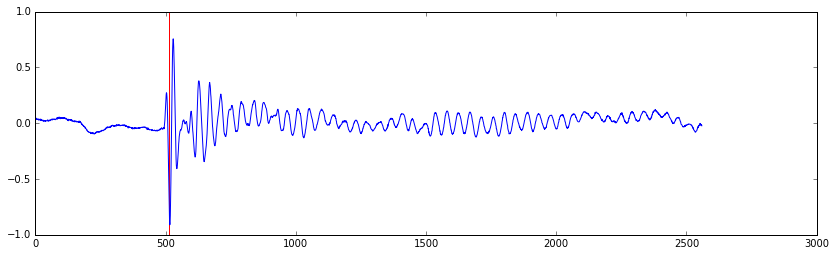

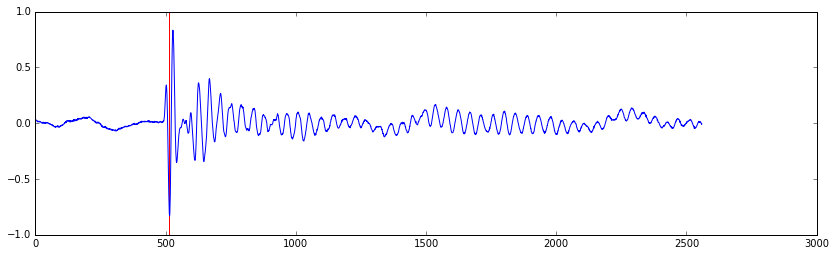

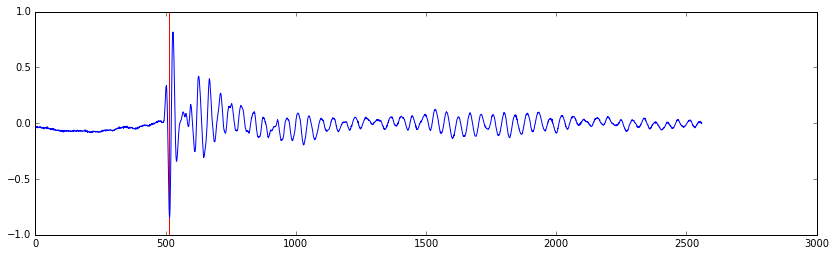

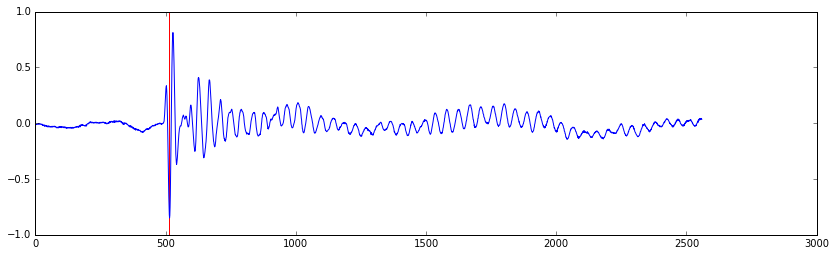

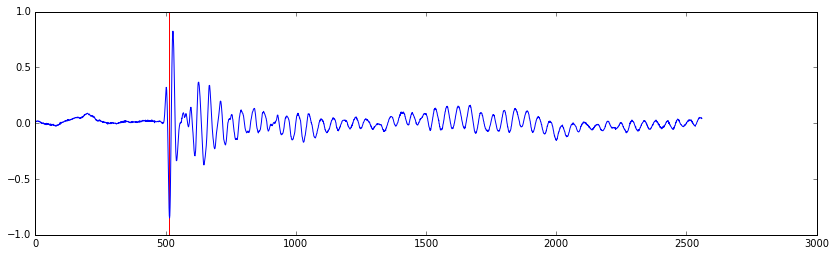

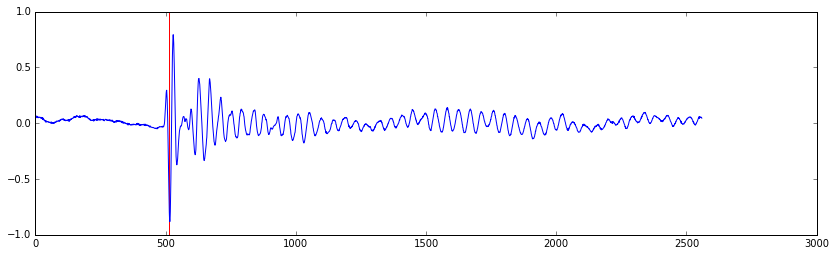

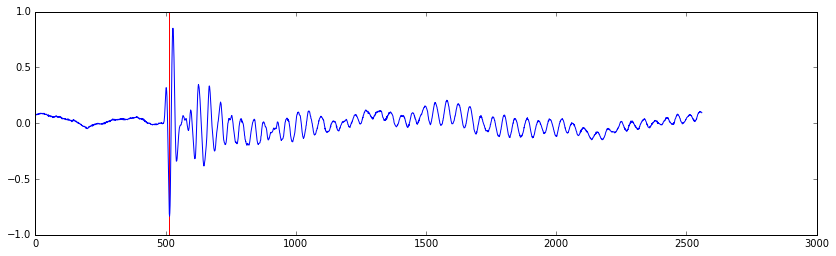

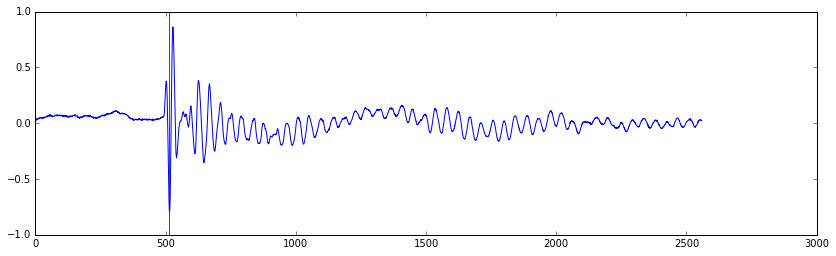

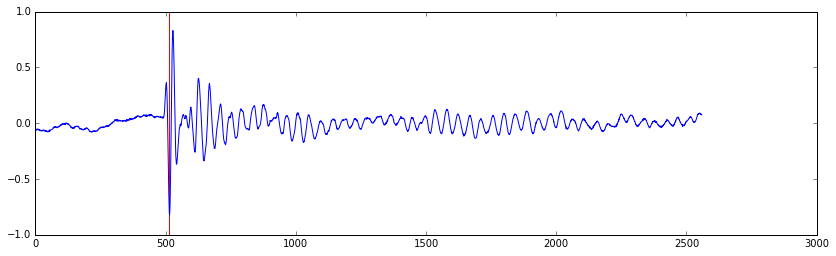

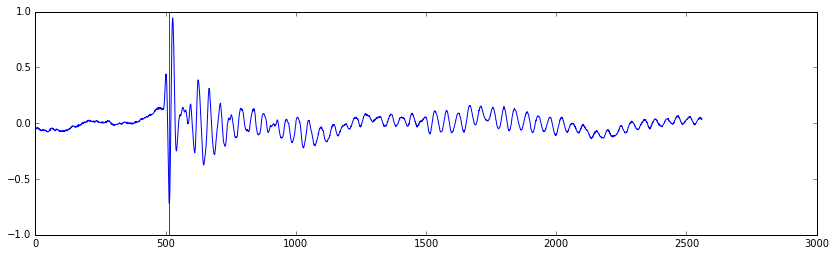

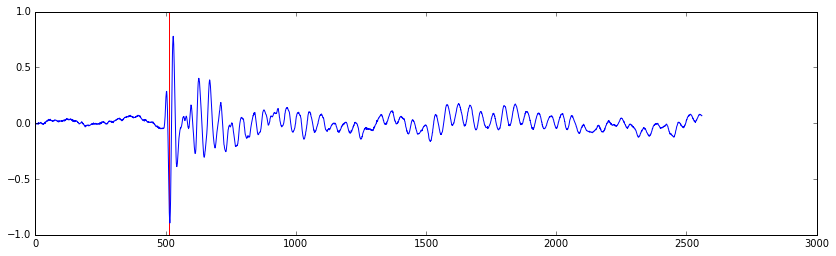

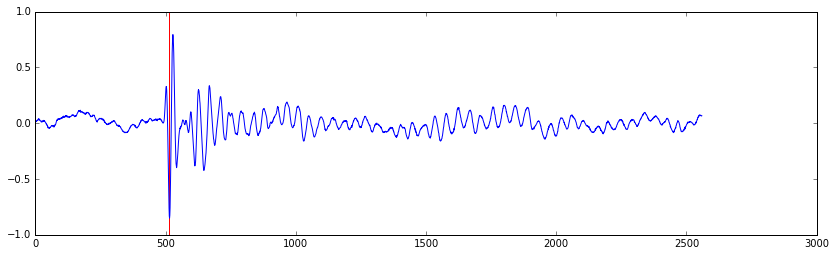

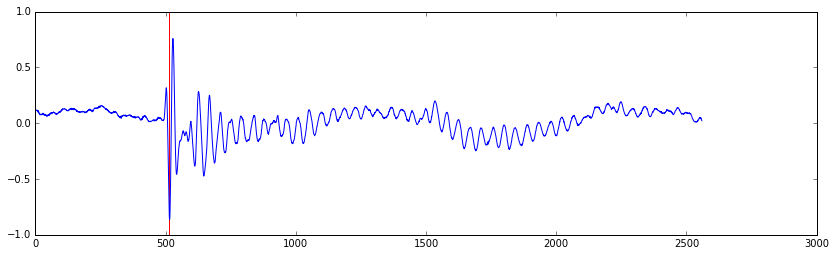

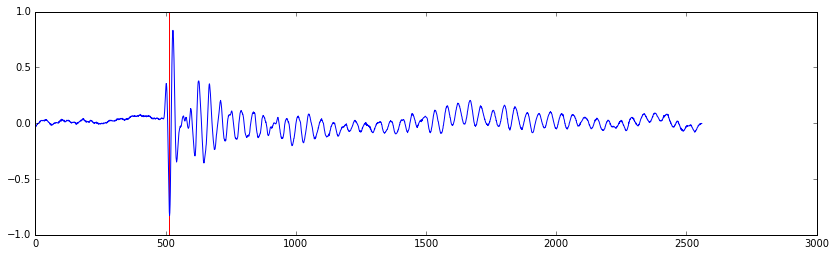

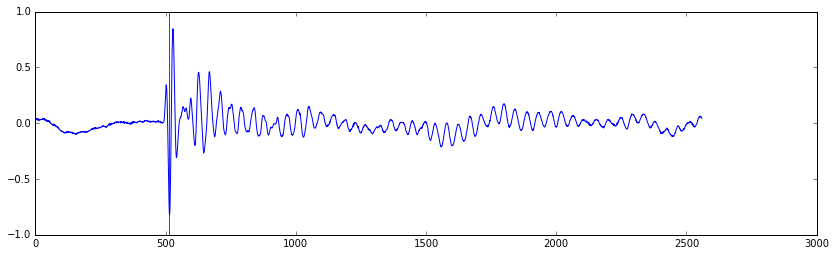

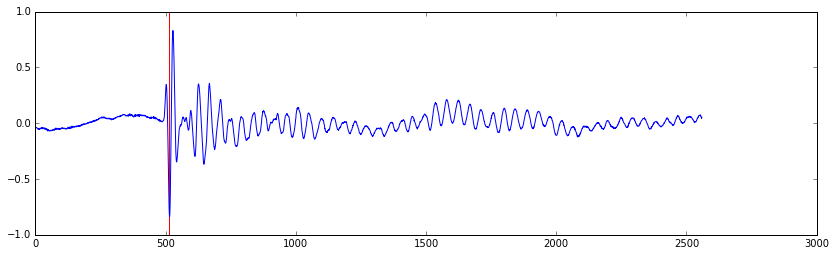

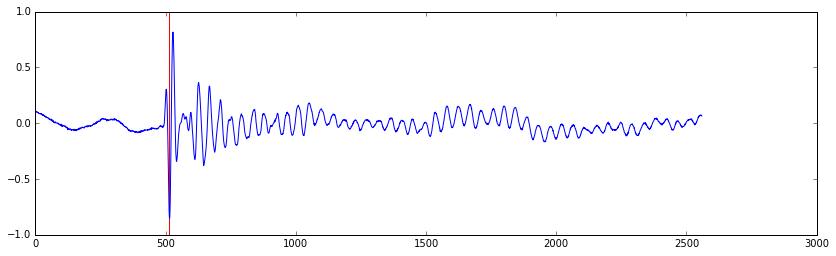

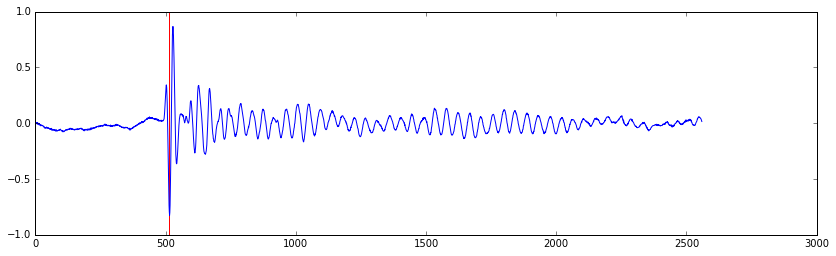

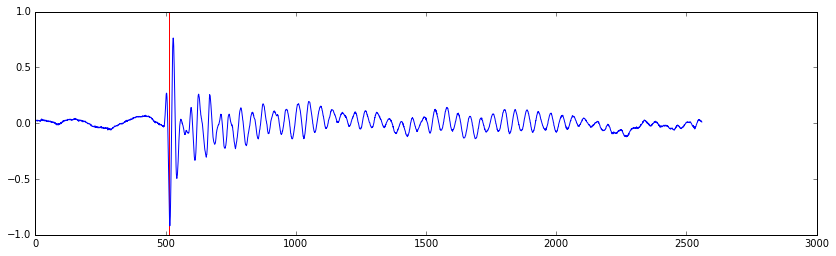

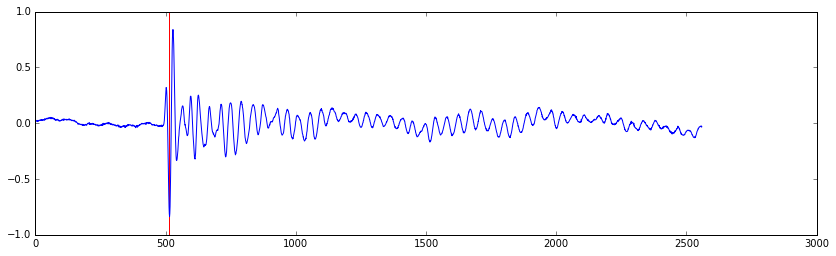

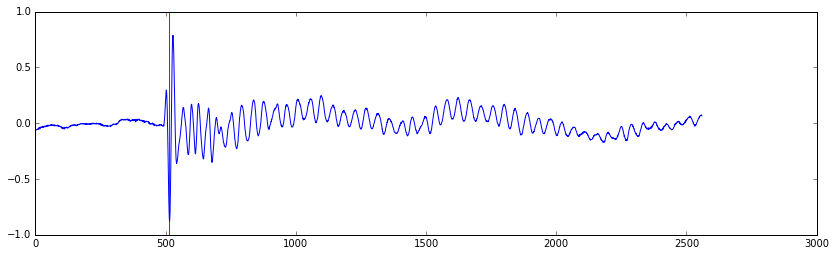

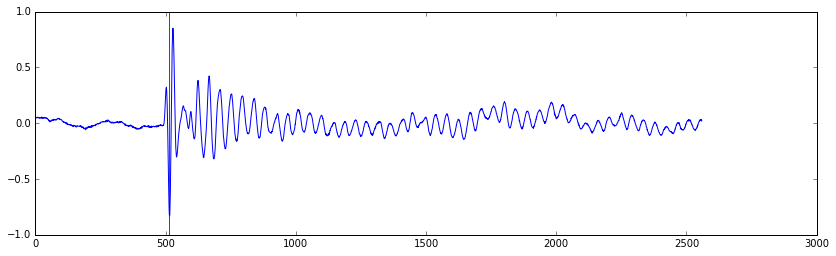

In [10]:
for onset_index in onset_indices:
    onset_pre_index = onset_index - HOP_LENGTH
    onset_post_index = onset_index + WIN_LENGTH
    onset_wave = record[onset_pre_index:onset_post_index]
    plt.plot(onset_wave)
    plt.vlines(HOP_LENGTH, -1, 1, color="r")
    plt.show()

## loopback latency

In [12]:
actual_click_times = []
for current_time, dac_time, playback_index in playback_info:
    for click_time in np.arange(0, click_duration, 1/click_bps):
        click_index = int(click_time*RATE)
        if playback_index <= click_index < playback_index+SAMPLES_PER_BUFFER:
            time_offset = (click_index - playback_index) / RATE
            actual_click_times.append(current_time + dac_time + time_offset)

In [13]:
actual_onset_times = []
for current_time, adc_time, record_index in record_info:
    for onset_index in onset_indices:
        if record_index <= onset_index < record_index+SAMPLES_PER_BUFFER:
            time_offset = (onset_index - record_index) / RATE
            actual_onset_times.append(current_time + adc_time + time_offset)

In [14]:
loopback_times = np.array(actual_onset_times) - np.array(actual_click_times)
print(loopback_times)
print("loopback latency:", np.mean(loopback_times))
print("loopback jitter:", np.std(loopback_times))

[0.03613583 0.09731528 0.12036766 0.09674793 0.09699033 0.09737178
 0.07456647 0.09658636 0.09770345 0.09686626 0.09765087 0.07289566
 0.0733965  0.09752015 0.12013208 0.09803631 0.09582622 0.07236596
 0.07487887 0.0961771  0.09794652 0.09629839 0.09723091 0.09780004
 0.09735918 0.09663653 0.07430608 0.09731286 0.07498343 0.09720936
 0.12005134 0.09661143]
loopback latency: 0.09228991087669697
loopback jitter: 0.016155308823017772


## internal error

In [15]:
dac_time_avg = 0
for current_time, dac_time, playback_index in playback_info:
    dac_time_avg += dac_time
dac_time_avg /= len(playback_info)
print("dac time:", dac_time_avg)

adc_time_avg = 0
for current_time, adc_time, record_index in record_info:
    adc_time_avg += adc_time
adc_time_avg /= len(record_info)
print("adc time:", adc_time_avg)


dac time: 0.009742213539996606
adc time: -0.013365597667638495


In [16]:
playback_error = []
for i, (current_time, dac_time, playback_index) in enumerate(playback_info):
    playback_time = playback_info[0][0] + i*SAMPLES_PER_BUFFER/RATE
    playback_error.append(current_time + dac_time - playback_time)
print("error of predicted playback time:", np.mean(playback_error))
print("std of predicted playback time:", np.std(playback_error))

record_error = []
for i, (current_time, adc_time, record_index) in enumerate(record_info):
    record_time = record_info[0][0] + i*SAMPLES_PER_BUFFER/RATE
    record_error.append(current_time + adc_time - record_time)
print("error of predicted record time:", np.mean(record_error))
print("std of predicted record time:", np.std(record_error))


error of predicted playback time: -0.06583925595428194
std of predicted playback time: 0.009656014225308677
error of predicted record time: -0.004874740070797802
std of predicted record time: 0.009793703788277661


In [17]:
actual_click_times_ = []
for i, (current_time, dac_time, playback_index) in enumerate(playback_info):
    playback_time = playback_info[0][0] + i*SAMPLES_PER_BUFFER/RATE
    for click_time in np.arange(0, click_duration, 1/click_bps):
        click_index = int(click_time*RATE)
        if playback_index <= click_index < playback_index+SAMPLES_PER_BUFFER:
            time_offset = (click_index - playback_index) / RATE
            actual_click_times_.append(playback_time + time_offset)

In [18]:
actual_onset_times_ = []
for i, (current_time, adc_time, record_index) in enumerate(record_info):
    record_time = record_info[0][0] + i*SAMPLES_PER_BUFFER/RATE
    for onset_index in onset_indices:
        if record_index <= onset_index < record_index+SAMPLES_PER_BUFFER:
            time_offset = (onset_index - record_index) / RATE
            actual_onset_times_.append(record_time + time_offset)

In [19]:
loopback_times_ = np.array(actual_onset_times_) - np.array(actual_click_times_)
print(loopback_times_)
print("loopback latency:", np.mean(loopback_times_))
print("loopback jitter:", np.std(loopback_times_))

[0.03557314 0.03557314 0.03555046 0.03557314 0.03557314 0.03555046
 0.03557314 0.03557314 0.03557314 0.03555046 0.03555046 0.03557314
 0.03557314 0.03557314 0.03557314 0.03555046 0.03557314 0.03557314
 0.03557314 0.03559581 0.03555046 0.03557314 0.03557314 0.03557314
 0.03557314 0.03557314 0.03557314 0.03557314 0.03555046 0.03557314
 0.03557314 0.03557314]
loopback latency: 0.03556888623572797
loopback jitter: 1.0510485384489835e-05
